# Procrastination POMDP Model

This notebook implements a generative POMDP model for procrastination using memo-lang.

**Model Overview:**
- Sequential decision-making over H=21 timesteps (3 steps/day × 7 days)
- Each participant p has:
  - Latent cost per task: θ[p, j] ~ Normal(μ[p, j], σ_θ)
  - Baseline work propensity: α[p] ~ Normal(0, σ_α)
  - Global urgency sensitivity: β_u (shared across participants)
- Prior mean μ[p, j] uses pre-study ratings (difficulty, concreteness, duration, rewardless)
- Dynamics per timestep:
  1. Choose action (attempt a task) among incomplete tasks using softmax policy
  2. Completion probability conditional on attempting task j: sigmoid(α[p] + β_u * urgency - θ[p, j])
- Observations: Task completion days (converted to timesteps)


## Installation and Setup

**Requirements:**
- Python >= 3.12
- memo-lang: `pip install memo-lang`
- JAX: `pip install jax` (CPU version)
- Other dependencies: numpy, pandas, matplotlib, scipy, jupyter


In [10]:
# Imports and setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from enum import IntEnum
from typing import no_type_check
import jax
import jax.numpy as jnp
from jax.scipy.stats.norm import pdf as norm_pdf
from jax.scipy.special import expit as sigmoid
from scipy.optimize import minimize
from memo import memo

# Set random seed for reproducibility
np.random.seed(42)
jax.config.update("jax_enable_x64", True)

# Set up paths
current_dir = Path.cwd()
if (current_dir / 'data').exists():
    PROJECT_ROOT = current_dir
elif (current_dir.parent / 'data').exists():
    PROJECT_ROOT = current_dir.parent
elif (current_dir.parent.parent / 'data').exists():
    PROJECT_ROOT = current_dir.parent.parent
else:
    PROJECT_ROOT = current_dir

PLOTS_DIR = PROJECT_ROOT / 'plots'
PLOTS_DIR.mkdir(exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Plots will be saved to: {PLOTS_DIR}")
print(f"JAX version: {jax.__version__}")

# Verify memo is installed
try:
    from memo import memo
    print("✓ memo-lang is installed")
except ImportError:
    print("✗ memo-lang is not installed. Run: pip install memo-lang")


Project root: /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project
Plots will be saved to: /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project/plots
JAX version: 0.8.1
✓ memo-lang is installed


## Data Loading and Preprocessing


In [11]:
# Load aggregated data
df = pd.read_csv(PROJECT_ROOT / 'data' / 'aggregated_data.csv')

# Generic mapping function for string values to integers (1-10)
def map_string_to_int(value, string_mapping, field_name):
    """
    Map string values to integers from 1-10.
    
    Args:
        value: String value or numeric value
        string_mapping: Dictionary mapping string keys to integer values (e.g., {'low': 2, 'medium': 5, 'high': 8})
        field_name: Name of the field being mapped (for warning messages, e.g., 'concreteness', 'difficulty', 'duration')
    
    Returns:
        Integer from 1-10
    """
    if pd.isna(value):
        return 5.0  # Default to middle value
    
    # If already numeric, return it (clamped to 1-10)
    if isinstance(value, (int, float)):
        return max(1, min(10, float(value)))
    
    # Map string values
    value_str = str(value).lower().strip()
    
    if value_str in string_mapping:
        return string_mapping[value_str]
    
    # If unrecognized, default to middle value
    print(f"Warning: Unrecognized {field_name} value '{value}', defaulting to 5")
    return 5.0

# Specific mapping functions using the generic helper
def map_concreteness_to_int(value):
    """Map string concreteness values ('low', 'medium', 'high') to integers from 1-10."""
    return map_string_to_int(value, {'low': 2, 'medium': 5, 'high': 8}, 'concreteness')

def map_difficulty_to_int(value):
    """Map string difficulty values ('easy', 'medium', 'hard') to integers from 1-10."""
    return map_string_to_int(value, {'easy': 2, 'medium': 5, 'hard': 8}, 'difficulty')

def map_duration_to_int(value):
    """Map string duration values ('short', 'medium', 'long') to integers from 1-10."""
    return map_string_to_int(value, {'short': 2, 'medium': 5, 'long': 8}, 'duration')

# Extract unique participants and tasks
participants = sorted(df['participant_id'].unique())
tasks = sorted(df['task'].unique())
n_participants = len(participants)
n_tasks = len(tasks)

print(f"Participants: {n_participants}")
print(f"Tasks: {n_tasks}")
print(f"\nParticipants: {participants}")
print(f"\nTasks: {tasks}")

# Create mappings
participant_to_idx = {p: i for i, p in enumerate(participants)}
task_to_idx = {t: i for i, t in enumerate(tasks)}
idx_to_task = {i: t for t, i in task_to_idx.items()}

# Extract task properties
task_data = {}
for task in tasks:
    task_row = df[df['task'] == task].iloc[0]
    
    # Map string values to integers
    concreteness_val = task_row['task_concreteness']
    concreteness_int = map_concreteness_to_int(concreteness_val)
    
    difficulty_val = task_row['task_difficulty']
    difficulty_int = map_difficulty_to_int(difficulty_val)
    
    duration_val = task_row['task_duration']
    duration_int = map_duration_to_int(duration_val)
    
    task_data[task] = {
        'deadline_day': int(task_row['task_deadline_day']),
        'points': float(task_row['task_points']),
        'concreteness': float(concreteness_int),  # Now always numeric
        'difficulty': float(difficulty_int),  # Now always numeric
        'duration': float(duration_int)  # Now always numeric
    }
    
    # Print mapping for first task to show it's working
    if task == tasks[0]:
        print(f"\nString-to-integer mapping example (first task):")
        print(f"  Task: {task}")
        print(f"  Concreteness: {concreteness_val} -> {concreteness_int}")
        print(f"  Difficulty: {difficulty_val} -> {difficulty_int}")
        print(f"  Duration: {duration_val} -> {duration_int}")

# Extract participant-task ratings
ratings = {}
for _, row in df.iterrows():
    p = row['participant_id']
    t = row['task']
    if p not in ratings:
        ratings[p] = {}
    ratings[p][t] = {
        'perceived_difficulty': float(row['perceived_difficulty']) if pd.notna(row['perceived_difficulty']) else None,
        'perceived_concreteness': float(row['perceived_concreteness']) if pd.notna(row['perceived_concreteness']) else None,
        'perceived_duration': float(row['perceived_duration']) if pd.notna(row['perceived_duration']) else None,
        'perceived_reward': float(row['perceived_reward']) if pd.notna(row['perceived_reward']) else None,
    }

# Extract completion times
completion_times = {}
for _, row in df.iterrows():
    p = row['participant_id']
    t = row['task']
    if p not in completion_times:
        completion_times[p] = {}
    if row['completed'] and pd.notna(row['relative_completion_day']):
        # Convert completion day to timestep (3 steps per day, 0-indexed)
        # Day 0 = timesteps 0-2, Day 1 = timesteps 3-5, etc.
        completion_day = int(row['relative_completion_day'])
        # Use the first timestep of that day (coarse mapping)
        completion_times[p][t] = completion_day * 3
    else:
        completion_times[p][t] = None  # Not completed

print(f"\nTask properties:")
for task in tasks:
    print(f"  {task}: deadline={task_data[task]['deadline_day']}, points={task_data[task]['points']}")

print(f"\nCompletion times (timesteps):")
for p in participants[:3]:  # Show first 3
    print(f"  {p}: {completion_times[p]}")


Participants: 6
Tasks: 8

Participants: ['aphid-1', 'aphid-2', 'gila monster', 'hummingbird', 'kingfisher', 'wagtail']

Tasks: ['Analyze a short passage', 'Complete a short quiz', 'Complete fraternity chore', 'Draw for ten minutes', 'Explain a difficult concept from class', 'Solve a logic puzzle', 'Sort a deck of cards', 'Write a brief reflection']

String-to-integer mapping example (first task):
  Task: Analyze a short passage
  Concreteness: low -> 2
  Difficulty: hard -> 8
  Duration: long -> 8

Task properties:
  Analyze a short passage: deadline=3, points=20.0
  Complete a short quiz: deadline=3, points=5.0
  Complete fraternity chore: deadline=5, points=25.0
  Draw for ten minutes: deadline=3, points=10.0
  Explain a difficult concept from class: deadline=1, points=20.0
  Solve a logic puzzle: deadline=5, points=15.0
  Sort a deck of cards: deadline=1, points=5.0
  Write a brief reflection: deadline=1, points=15.0

Completion times (timesteps):
  aphid-1: {'Sort a deck of cards':

## Model Hyperparameters

Set hyperparameters for priors and model dynamics:


In [12]:
# Model hyperparameters
H = 21  # Total timesteps (3 per day × 7 days)
STEPS_PER_DAY = 3
GAMMA = 0.9  # Lateness discount factor
ETA = 1.0  # Softmax temperature for action selection

# Prior hyperparameters
SIGMA_THETA = 2.0  # Prior std for θ[p, j]
SIGMA_ALPHA = 1.0  # Prior std for α[p]
SIGMA_BETA = 1.0  # Prior std for β_u

# Prior mean weights (for μ[p, j] = w_d * diff + w_c * (10-conc) + w_tau * dur + w_r * rewardless)
W_DIFFICULTY = 0.5
W_CONCRETENESS = 0.3  # Note: using (10 - concreteness) so higher concreteness = lower cost
W_DURATION = 0.4
W_REWARDLESS = 0.2  # Note: using perceived_reward, so higher reward = lower cost (inverse)

print(f"Model configuration:")
print(f"  H = {H} timesteps ({H // STEPS_PER_DAY} days)")
print(f"  γ = {GAMMA}")
print(f"  η = {ETA}")
print(f"  σ_θ = {SIGMA_THETA}, σ_α = {SIGMA_ALPHA}, σ_β = {SIGMA_BETA}")


Model configuration:
  H = 21 timesteps (7 days)
  γ = 0.9
  η = 1.0
  σ_θ = 2.0, σ_α = 1.0, σ_β = 1.0


## Compute Prior Means μ[p, j]

Compute prior means for θ[p, j] using pre-study ratings:


In [13]:
# Compute prior means μ[p, j] for each participant-task pair
mu_prior = np.zeros((n_participants, n_tasks))

for p_idx, p in enumerate(participants):
    for t_idx, t in enumerate(tasks):
        rating = ratings[p][t]
        
        # Extract ratings (use defaults if missing)
        diff = rating['perceived_difficulty'] if rating['perceived_difficulty'] is not None else 5.0
        conc = rating['perceived_concreteness'] if rating['perceived_concreteness'] is not None else 5.0
        dur = rating['perceived_duration'] if rating['perceived_duration'] is not None else 5.0
        reward = rating['perceived_reward'] if rating['perceived_reward'] is not None else 5.0
        
        # Compute prior mean: higher difficulty, lower concreteness, longer duration, lower reward → higher cost
        mu = (W_DIFFICULTY * diff + 
              W_CONCRETENESS * (10 - conc) +  # Higher concreteness → lower cost
              W_DURATION * dur + 
              W_REWARDLESS * (10 - reward))  # Higher reward → lower cost
        
        mu_prior[p_idx, t_idx] = mu

print("Prior means μ[p, j] (first few):")
print(mu_prior[:3, :])


Prior means μ[p, j] (first few):
[[7.3 3.1 3.8 5.7 6.8 4.9 3.3 3.7]
 [8.5 3.  7.3 4.2 7.9 5.3 2.7 6.9]
 [6.6 5.2 8.1 4.5 5.3 4.3 2.6 7.5]]


## Model Setup

Helper functions and enums for the generative model:


In [ ]:
# Define enums for memo
# Use functional API to dynamically create enum members
TaskIdx = IntEnum('TaskIdx', {f'TASK_{i}': i for i in range(n_tasks)})

# Create task array for memo
TASK_ARRAY = np.array(list(range(n_tasks)))

# Helper function to get day from timestep
# JAX supports // operator natively
def day_from_timestep(t):
    """Convert timestep t to day (0-indexed)"""
    return t // STEPS_PER_DAY

# Helper function to compute lateness
# Use jnp.maximum here (it's OK in helper functions, just not in memo expressions)
# JAX can trace through jnp.maximum in helper functions
@jax.jit
def lateness(t, deadline_day):
    """Compute lateness at timestep t for task with deadline_day"""
    current_day = day_from_timestep(t)
    return jnp.maximum(0, current_day - deadline_day)

# Helper function to compute day from timestep (for use in memo expressions)
# Memo doesn't support // operator, so we use regular division
# This function will be called via memo's ffi mechanism
# Returns float to avoid dimension issues
@jax.jit
def get_day(t):
    """Convert timestep t to day (0-indexed) using regular division"""
    # Use regular division - return as float (memo handles floats better than int conversions)
    return t / 3.0

print(f"Task array: {TASK_ARRAY}")
print(f"Task enum: {[getattr(TaskIdx, f'TASK_{i}') for i in range(n_tasks)]}")


Task array: [0 1 2 3 4 5 6 7]
Task enum: [0, 1, 2, 3, 4, 5, 6, 7]


## POMDP Generative Model

We model the completion time for each task as a function of the sequential decision process.
Since memo doesnt support loops, we model the probability of completing at each timestep
by computing the utility-based probability that accounts for:
1. The probability of attempting the task (softmax over incomplete tasks)
2. The probability of completing given an attempt (sigmoid)
3. The probability that it wasnt completed earlier


## POMDP Generative Model Implementation

We implement a generative model that captures the POMDP dynamics:
- Action selection via softmax over incomplete tasks
- Completion probability via sigmoid given an attempt
- Observations of completion times

The model computes the probability distribution over completion times for each task,
which we then use for MAP inference over the latent parameters θ[p,j], α[p], and β_u.


In [20]:
# POMDP generative model for task completion times
# We model the probability of completing each task at each timestep

# Create CompletionTime enum properly using Python's functional API
# This is the correct way to create enums dynamically
CompletionTime = IntEnum(
    'CompletionTime',
    {f'T{t}': t for t in range(H + 1)},
    module=__name__
)
COMPLETION_TIMES = np.array(list(range(H + 1)))  # 0 to H

# Verify enum is set up correctly
print(f"CompletionTime enum has {len(list(CompletionTime))} values")
print(f"First few enum values: {[getattr(CompletionTime, f'T{i}') for i in range(min(5, H+1))]}")
print(f"Last enum value: {getattr(CompletionTime, f'T{H}')}")

# Test with a simple memo function first to verify enum works
@memo
def test_simple[t_complete: CompletionTime]():
    agent: chooses(t_complete in CompletionTime, wpp=1)
    return Pr[agent.t_complete == t_complete]

print("\nTesting simple memo function with enum...")
try:
    test_simple_result = test_simple()
    print(f"Simple test passed! Output shape: {test_simple_result.shape}, sum: {test_simple_result.sum():.4f}")
except Exception as e:
    print(f"Simple test failed: {e}")
    import traceback
    traceback.print_exc()

# ruff: noqa
@no_type_check
@memo
def task_completion_time[t_complete: CompletionTime](
    theta_j,  # θ[p, j] for this task
    alpha,  # α[p]
    beta_u,  # β_u
    V_j,  # V[j] reward points
    deadline_day,  # d[j] deadline day
    mu_prior_j  # Prior mean μ[p, j] (for prior, not used in likelihood here)
):
    """
    Generative model for when task j gets completed.
    
    Models the completion time distribution based on POMDP dynamics:
    - At each timestep t, compute score[j] = eta * (V[j] * γ^lateness - θ[p,j])
    - Probability of attempting task j (softmax over incomplete tasks)
    - Probability of completing given attempt: sigmoid(α[p] + β_u * urgency - θ[p,j])
    - Overall: probability of completing at t is attempt_prob * completion_prob * (1 - earlier_completion)
    
    For computational efficiency, we approximate by computing utility at each timestep
    and using softmax to get completion time distribution.
    
    Args:
        t_complete: Completion timestep (axis) - 0 to H (H = never completed)
        theta_j: Latent cost θ[p, j]
        alpha: Baseline work propensity α[p]
        beta_u: Urgency sensitivity β_u
        V_j: Reward points
        deadline_day: Deadline day
        mu_prior_j: Prior mean μ[p, j]
    
    Returns:
        Probability of completing at timestep t_complete
    """
    # Compute utility for completing at timestep t_complete
    # Memo doesn't support assignments, if statements, or jnp.where
    # Use Python ternary operator (x if condition else y) - memo supports this
    # Memo doesn't support // operator, so use regular division / and convert to int
    # Compute day from timestep: day = int(t_complete / 3.0)
    # Compute lateness: max(0, day - deadline_day)
    # All computations must be inlined in the expression (no assignments)
    
    # Inline all computations directly in the wpp expression using ternary operator
    # Utility = -20.0 if t_complete == 21 (H) else (completed utility)
    # Note: Use integer 21 directly since memo can't access external constant H
    # Use literal values: ETA=1.0 (removed since it's 1.0), GAMMA=0.9 (memo can't access external constants)
    # Compute day using regular division: t_complete / 3.0, then convert to int using helper function
    
    # Compute day using regular division (memo supports / but not //)
    # day = t_complete / 3.0 (will be float, but that's OK for arithmetic)
    # lateness = max(0, day - deadline_day) using ternary operator
    # Since we can't use assignments, compute lateness value inline in each use
    agent: chooses(t_complete in CompletionTime, wpp=exp(
        -20.0 if t_complete == 21 else (
            # Completed case: combine attempt score and completion bonus
            # Use literal values: ETA=1.0, GAMMA=0.9 (memo can't access external constants)
            # Compute day: t_complete / 3.0 (float division, OK for arithmetic)
            # Compute lateness: max(0, (t_complete / 3.0) - deadline_day) using ternary
            # Note: We compute (t_complete / 3.0) multiple times - memo should optimize this
            (V_j * (0.9 ** (((t_complete / 3.0) - deadline_day) if ((t_complete / 3.0) - deadline_day) > 0 else 0)) - theta_j) +
            (alpha + beta_u * (((t_complete / 3.0) - deadline_day) if ((t_complete / 3.0) - deadline_day) > 0 else 0) - theta_j)
        )
    ))
    
    return Pr[agent.t_complete == t_complete]

print("Testing task_completion_time model...")
try:
    test_result = task_completion_time(2.0, 1.0, 0.5, 15.0, 1, 2.5)
    print(f"Output shape: {test_result.shape}")
    print(f"Sum: {test_result.sum():.4f}")
    print(f"First few probabilities: {test_result[:5]}")
    print("Model works!")
except Exception as e:
    print(f"Model test error: {e}")
    import traceback
    traceback.print_exc()


CompletionTime enum has 22 values
First few enum values: [<CompletionTime.T0: 0>, <CompletionTime.T1: 1>, <CompletionTime.T2: 2>, <CompletionTime.T3: 3>, <CompletionTime.T4: 4>]
Last enum value: 21

Testing simple memo function with enum...
Simple test passed! Output shape: (22,), sum: 1.0000
Testing task_completion_time model...
Output shape: (22,)
Sum: 1.0000
First few probabilities: [0.14709646 0.14709646 0.14709646 0.14709646 0.10355433]
Model works!


In [21]:
def compute_log_likelihood_participant(
    params,  # [theta_0, ..., theta_{n_tasks-1}, alpha, beta_u]
    participant_idx,
    observed_completion_times,  # Dict mapping task_idx -> completion_timestep (or None)
    V_array,  # Array of V[j] for all tasks
    deadlines_array,  # Array of d[j] for all tasks
    mu_prior_participant  # Array of μ[p, j] for this participant
):
    """
    Compute log-likelihood for a single participant.
    
    This function implements MAP inference by computing:
    log P(θ, α, β_u | observations) ∝ log P(observations | θ, α, β_u) + log P(θ, α, β_u)
    
    Args:
        params: Parameter vector [θ[0], ..., θ[n_tasks-1], α, β_u]
        participant_idx: Participant index
        observed_completion_times: Dict {task_idx: completion_timestep or None}
        V_array: Reward points for all tasks
        deadlines_array: Deadline days for all tasks
        mu_prior_participant: Prior means for this participant
    
    Returns:
        Negative log-likelihood (for minimization)
    """
    n_tasks_local = len(V_array)
    theta = params[:n_tasks_local]
    alpha = params[n_tasks_local]
    beta_u = params[n_tasks_local + 1]
    
    # Prior terms (log probabilities)
    # θ[p, j] ~ Normal(μ[p, j], σ_θ)
    log_prior_theta = jnp.sum(jax.scipy.stats.norm.logpdf(theta, mu_prior_participant, SIGMA_THETA))
    # α[p] ~ Normal(0, σ_α)
    log_prior_alpha = jax.scipy.stats.norm.logpdf(alpha, 0.0, SIGMA_ALPHA)
    # β_u ~ Normal(0, σ_β)
    log_prior_beta = jax.scipy.stats.norm.logpdf(beta_u, 0.0, SIGMA_BETA)
    log_prior = log_prior_theta + log_prior_alpha + log_prior_beta
    
    # Likelihood term: product over tasks
    # P(observations | θ, α, β_u) = ∏_j P(t_complete[j] | θ[p,j], α[p], β_u)
    log_likelihood = 0.0
    
    for task_idx in range(n_tasks_local):
        # Get model probabilities from memo model
        # Don't use float() - JAX needs to trace through these values
        # Convert to JAX arrays/scalars instead
        probs = task_completion_time(
            theta[task_idx],  # JAX array element
            alpha,  # JAX scalar
            beta_u,  # JAX scalar
            V_array[task_idx],  # numpy array element (will be converted)
            deadlines_array[task_idx],  # numpy array element
            mu_prior_participant[task_idx]  # numpy array element
        )
        
        # Get observed completion time
        obs_time = observed_completion_times.get(task_idx, None)
        
        if obs_time is not None:
            # Task was completed at timestep obs_time
            # Clamp to valid range [0, 21]
            obs_time_clamped = int(np.clip(obs_time, 0, 21))  # H = 21
            if obs_time_clamped < len(probs):
                prob = probs[obs_time_clamped]  # Keep as JAX array, don't convert to float
                log_likelihood += jnp.log(prob + 1e-10)
            else:
                # Fallback: use never-completed probability
                if len(probs) > 21:  # H = 21
                    prob = probs[21]  # Keep as JAX array
                    log_likelihood += jnp.log(prob + 1e-10)
        else:
            # Task was never completed (completion at timestep H)
            if len(probs) > 21:  # H = 21
                prob = probs[21]  # Keep as JAX array
                log_likelihood += jnp.log(prob + 1e-10)
    
    # Return negative log-likelihood (for minimization)
    return -(log_prior + log_likelihood)

# Create JAX-compatible version with gradients
compute_loss_and_grad = jax.value_and_grad(compute_log_likelihood_participant)

print("Log-likelihood function created")


Log-likelihood function created


In [22]:
# Prepare data arrays for fitting
V_array = np.array([task_data[t]['points'] for t in tasks])
deadlines_array = np.array([task_data[t]['deadline_day'] for t in tasks])

print("Task rewards V:", V_array)
print("Task deadlines d:", deadlines_array)

# Fit parameters for each participant
fitted_params = {}

for p_idx, participant in enumerate(participants):
    print(f"\nFitting parameters for {participant}...")
    
    # Prepare observed completion times for this participant
    obs_times = {}
    for t_idx, task in enumerate(tasks):
        comp_time = completion_times[participant].get(task, None)
        if comp_time is not None:
            obs_times[t_idx] = comp_time
        # else: task not completed, will be handled as completion at H
    
    # Initialize parameters
    # Start with prior means for theta, small values for alpha and beta_u
    initial_theta = mu_prior[p_idx, :].copy()
    initial_alpha = 0.0
    initial_beta_u = 0.0
    initial_params = np.concatenate([initial_theta, [initial_alpha, initial_beta_u]])
    
    # Objective function for scipy.optimize
    def objective(x):
        loss, grad = compute_loss_and_grad(
            x,
            p_idx,
            obs_times,
            V_array,
            deadlines_array,
            mu_prior[p_idx, :]
        )
        return float(loss), np.array([float(g) for g in grad])
    
    # Optimize
    result = minimize(
        objective,
        x0=initial_params,
        method='L-BFGS-B',
        jac=True,
        options={'maxiter': 100}
    )
    
    # Extract fitted parameters
    n_tasks_local = len(tasks)
    fitted_theta = result.x[:n_tasks_local]
    fitted_alpha = result.x[n_tasks_local]
    fitted_beta_u = result.x[n_tasks_local + 1]
    
    fitted_params[participant] = {
        'theta': fitted_theta,
        'alpha': fitted_alpha,
        'beta_u': fitted_beta_u
    }
    
    print(f"  α = {fitted_alpha:.3f}, β_u = {fitted_beta_u:.3f}")
    print(f"  θ = {fitted_theta}")

# Extract shared beta_u (use mean across participants)
shared_beta_u = np.mean([fitted_params[p]['beta_u'] for p in participants])
print(f"\nShared β_u (mean): {shared_beta_u:.3f}")

# Update all participants to use shared beta_u
for participant in participants:
    fitted_params[participant]['beta_u'] = shared_beta_u


Task rewards V: [20.  5. 25. 10. 20. 15.  5. 15.]
Task deadlines d: [3 3 5 3 1 5 1 1]

Fitting parameters for aphid-1...
  α = -1.971, β_u = -0.796
  θ = [15.29953695  3.10000001  3.79999979 13.46802398  6.8         4.9
  3.30000009  3.7       ]

Fitting parameters for aphid-2...
  α = -2.994, β_u = 0.603
  θ = [16.48778511  2.99999996  7.30594651 12.16547068 15.89230143  5.3
  2.69999999  6.89999999]

Fitting parameters for gila monster...
  α = -6.258, β_u = -0.736
  θ = [14.5920275  10.32319371 16.09927385 11.86070754  5.3        12.29262147
  9.39901755 14.29880188]

Fitting parameters for hummingbird...
  α = -4.679, β_u = -0.566
  θ = [14.49865575 11.47341601  5.20048921 12.78920602  3.5086002  12.89490536
 11.31360484 14.75201603]

Fitting parameters for kingfisher...
  α = -3.902, β_u = -0.781
  θ = [15.59446274  4.79999334  4.80009893  5.29999987 14.19921394  5.1
 10.32247362 12.49635246]

Fitting parameters for wagtail...
  α = -3.769, β_u = -0.362
  θ = [17.69418505  4.39999

## Visualization 1: Predicted vs Observed Completion Days

For each participant, plot predicted completion-day distribution per task vs observed completion day.


Figure saved as /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project/plots/procrastination_pomdp_predicted_vs_observed.png


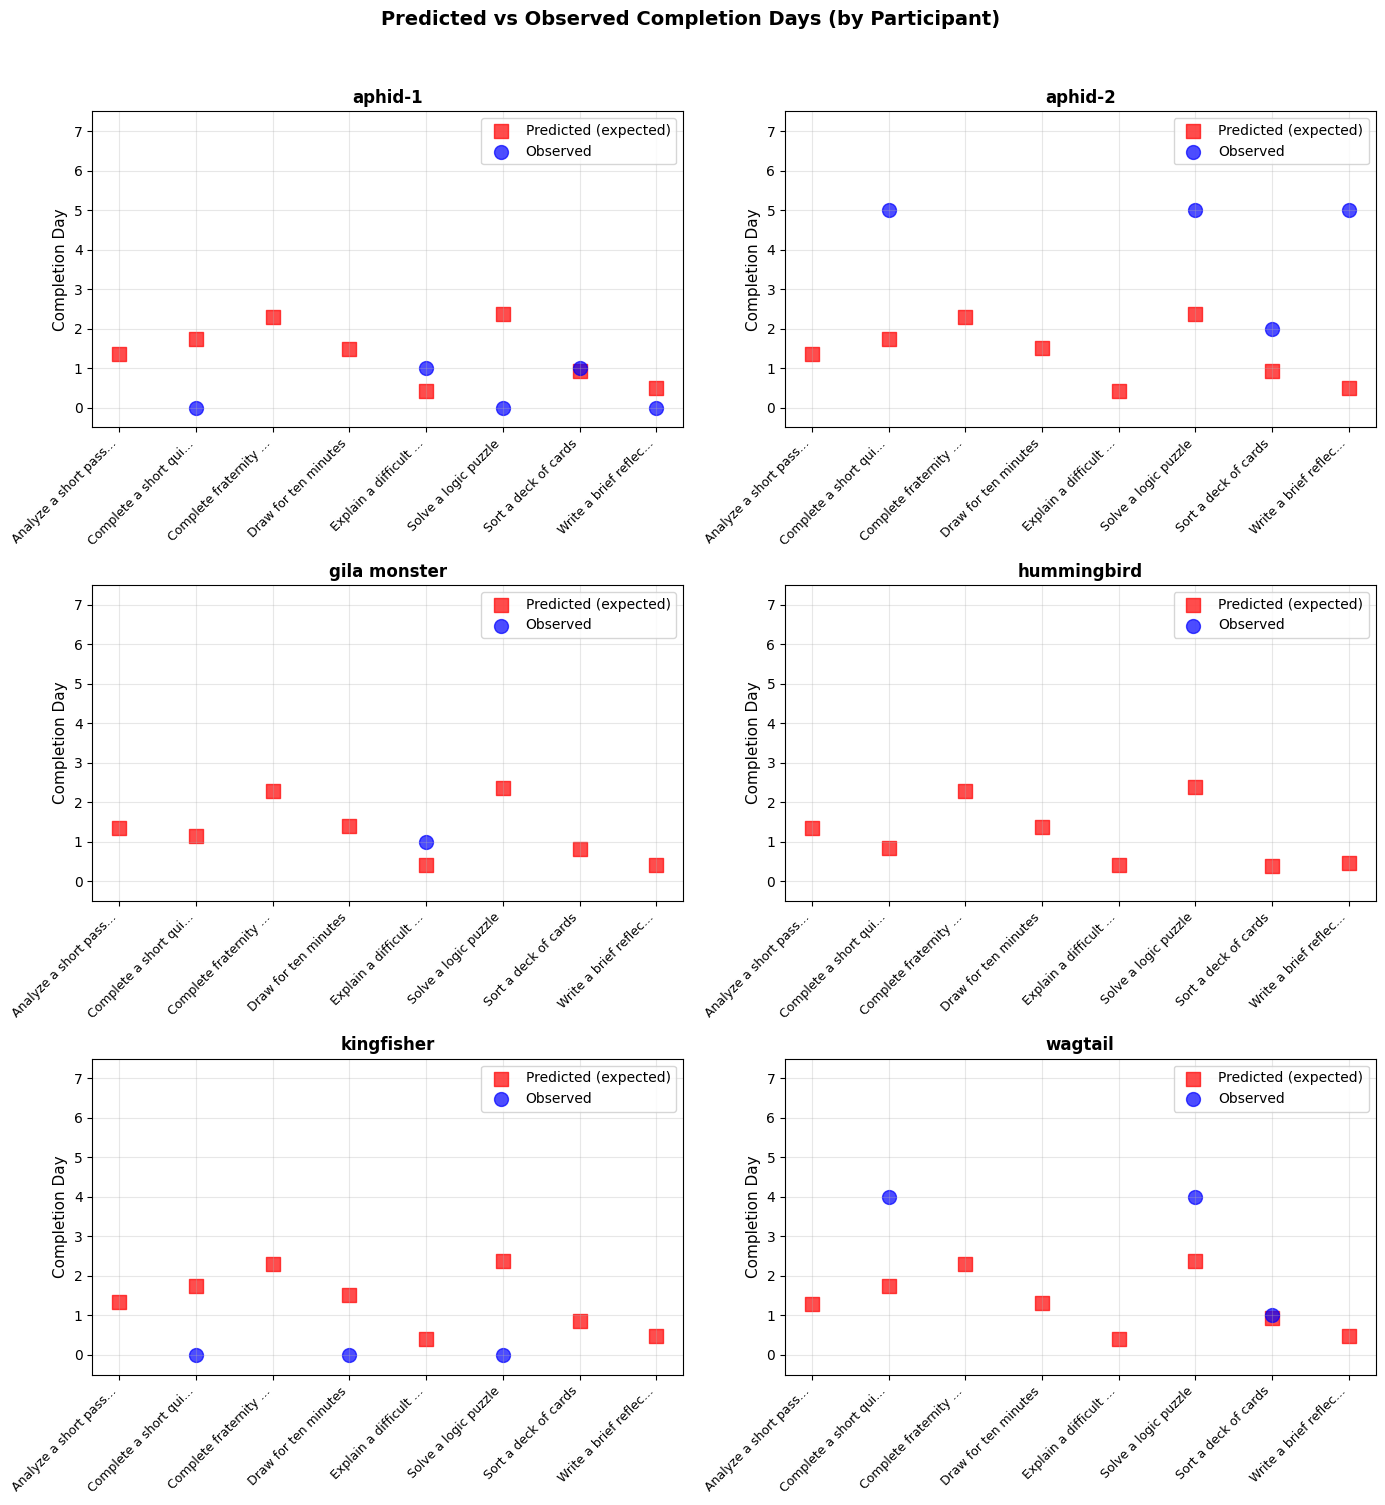

In [23]:
# Compute predicted completion day distributions for each participant-task
predictions = []

for p_idx, participant in enumerate(participants):
    params = fitted_params[participant]
    theta = params['theta']
    alpha = params['alpha']
    beta_u = params['beta_u']
    
    for t_idx, task in enumerate(tasks):
        # Get model probabilities
        probs = task_completion_time(
            float(theta[t_idx]),
            float(alpha),
            float(beta_u),
            float(V_array[t_idx]),
            int(deadlines_array[t_idx]),
            float(mu_prior[p_idx, t_idx])
        )
        
        # Convert timestep probabilities to day probabilities
        day_probs = np.zeros(8)  # Days 0-7
        for timestep in range(min(H, len(probs))):
            day = day_from_timestep(timestep)
            if day < 8:
                day_probs[day] += probs[timestep]
        # Never completed goes to day 7+ (or we can ignore it)
        
        # Compute expected completion day
        expected_day = np.sum([d * day_probs[d] for d in range(8)])
        
        # Get observed completion day
        obs_time = completion_times[participant].get(task, None)
        if obs_time is not None:
            obs_day = day_from_timestep(obs_time)
        else:
            obs_day = None
        
        predictions.append({
            'participant': participant,
            'task': task,
            'expected_day': expected_day,
            'observed_day': obs_day,
            'day_probs': day_probs
        })

df_predictions = pd.DataFrame(predictions)

# Plot: Predicted vs Observed for each participant
n_participants_plot = len(participants)
n_cols = 2
n_rows = (n_participants_plot + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
if n_participants_plot == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for p_idx, participant in enumerate(participants):
    ax = axes[p_idx]
    participant_data = df_predictions[df_predictions['participant'] == participant]
    
    # Plot predicted (expected) completion days
    ax.scatter(
        range(len(participant_data)),
        participant_data['expected_day'],
        label='Predicted (expected)',
        s=100,
        alpha=0.7,
        color='red',
        marker='s'
    )
    
    # Plot observed completion days
    observed_data = participant_data[participant_data['observed_day'].notna()]
    ax.scatter(
        [i for i, (_, row) in enumerate(participant_data.iterrows()) if pd.notna(row['observed_day'])],
        observed_data['observed_day'],
        label='Observed',
        s=100,
        alpha=0.7,
        color='blue',
        marker='o'
    )
    
    # Add task labels
    ax.set_xticks(range(len(participant_data)))
    ax.set_xticklabels([t[:20] + '...' if len(t) > 20 else t for t in participant_data['task']], 
                       rotation=45, ha='right', fontsize=9)
    
    ax.set_ylabel('Completion Day', fontsize=11)
    ax.set_title(f'{participant}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.5, 7.5)

# Hide unused subplots
for i in range(n_participants_plot, len(axes)):
    axes[i].axis('off')

plt.suptitle('Predicted vs Observed Completion Days (by Participant)', 
             fontsize=14, fontweight='bold', y=1.0)
plt.tight_layout(rect=[0, 0, 1, 0.98])

plot_path = PLOTS_DIR / 'procrastination_pomdp_predicted_vs_observed.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Figure saved as {plot_path}")
plt.show()


Figure saved as /Users/briosolivares/Desktop/MIT/fa25/ccs-final-project/plots/procrastination_pomdp_theta_vs_ratings.png


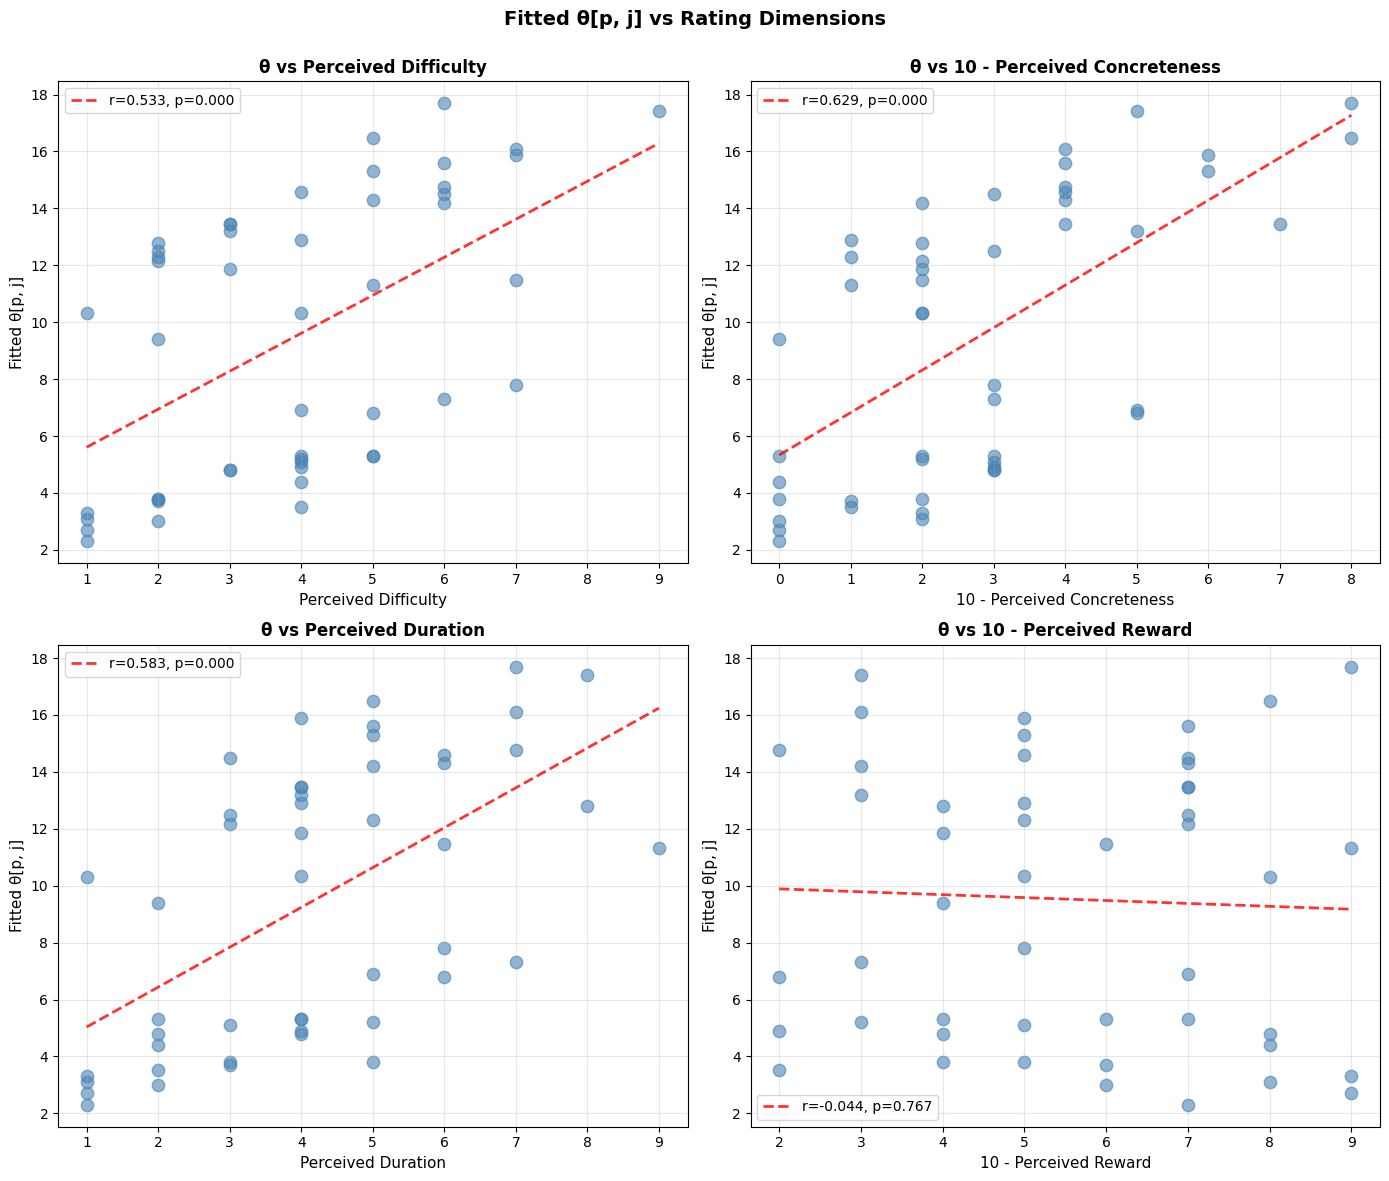


Correlations between θ and rating dimensions:
  Perceived Difficulty: r = 0.533
  10 - Perceived Concreteness: r = 0.629
  Perceived Duration: r = 0.583
  10 - Perceived Reward: r = -0.044


In [24]:
# Prepare data for scatter plots
scatter_data = []

for p_idx, participant in enumerate(participants):
    params = fitted_params[participant]
    theta = params['theta']
    
    for t_idx, task in enumerate(tasks):
        rating = ratings[participant][task]
        
        # Extract ratings
        diff = rating['perceived_difficulty'] if rating['perceived_difficulty'] is not None else np.nan
        conc = rating['perceived_concreteness'] if rating['perceived_concreteness'] is not None else np.nan
        dur = rating['perceived_duration'] if rating['perceived_duration'] is not None else np.nan
        reward = rating['perceived_reward'] if rating['perceived_reward'] is not None else np.nan
        
        scatter_data.append({
            'participant': participant,
            'task': task,
            'theta': theta[t_idx],
            'difficulty': diff,
            'concreteness_inv': 10 - conc if not np.isnan(conc) else np.nan,
            'duration': dur,
            'rewardless': 10 - reward if not np.isnan(reward) else np.nan
        })

df_scatter = pd.DataFrame(scatter_data)

# Create subplots for each rating dimension
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

rating_dims = [
    ('difficulty', 'Perceived Difficulty'),
    ('concreteness_inv', '10 - Perceived Concreteness'),
    ('duration', 'Perceived Duration'),
    ('rewardless', '10 - Perceived Reward')
]

for idx, (dim, label) in enumerate(rating_dims):
    ax = axes[idx]
    
    # Filter out NaN values
    plot_data = df_scatter[[dim, 'theta']].dropna()
    
    if len(plot_data) > 0:
        # Scatter plot
        ax.scatter(plot_data[dim], plot_data['theta'], alpha=0.6, s=80, color='steelblue')
        
        # Regression line
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, std_err = linregress(plot_data[dim], plot_data['theta'])
        x_line = np.linspace(plot_data[dim].min(), plot_data[dim].max(), 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r--', alpha=0.8, linewidth=2, 
               label=f'r={r_value:.3f}, p={p_value:.3f}')
        
        ax.set_xlabel(label, fontsize=11)
        ax.set_ylabel('Fitted θ[p, j]', fontsize=11)
        ax.set_title(f'θ vs {label}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'θ vs {label}', fontsize=12, fontweight='bold')

plt.suptitle('Fitted θ[p, j] vs Rating Dimensions', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])

plot_path = PLOTS_DIR / 'procrastination_pomdp_theta_vs_ratings.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Figure saved as {plot_path}")
plt.show()

# Print correlations
print("\nCorrelations between θ and rating dimensions:")
for dim, label in rating_dims:
    plot_data = df_scatter[[dim, 'theta']].dropna()
    if len(plot_data) > 1:
        corr = plot_data[dim].corr(plot_data['theta'])
        print(f"  {label}: r = {corr:.3f}")
